# Merging

Files needed = (gameshow.csv, gameshow_champs.csv, ml-latest-small.zip)

We will often find ourselves with variables spread across different datasets and files. We *merge* datasets together by matching up the two datasets on one or more variables. For example, I might have GDP data by country from the Penn World Tables, and demographic data by country from the World Bank. We would merge these two datasets and match up the observations by country. 

Some of the most powerful analysis comes from combining data from different sources. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### The data

Let's return to the 'gameshow.csv' file that tracks performance for Taskmaster contestants. 

In [2]:
game = pd.read_csv('gameshow.csv')
game.dtypes

series          int64
contestant     object
episode         int64
var            object
value         float64
dtype: object

In [3]:
game.sample(5)

,series,contestant,episode,var,value
1128,12,Desiree Burch,5,score,8.0
484,5,Sally Phillips,3,score,16.0
57,1,Roisin Conaty,9,win,NaN
1293,13,Sophie Duker,7,win,1.0
637,7,Jessica Knappett,9,win,0.0


The data are stacked. I move everything but the values into the index, and then unstack 'var'. 

In [4]:
# move everything but the data values to the index
game = game.set_index(['series', 'contestant', 'episode', 'var'])
game = game.sort_index()

# We pass unstack the name of the index level to take out of the index and spread across the rows. 
game = game.unstack('var') 

# Let's also get rid of "missings" - episodes that didn't exist in the season
game.dropna(inplace=True)
game.head(10)

value     
var                            score  win
series contestant      episode           
1      Frank Skinner   1        19.0  1.0
                       2         9.0  0.0
                       3        15.0  0.0
                       4        14.0  0.0
                       5        20.0  1.0
                       6        16.0  0.0
       Josh Widdicombe 1        13.0  0.0
                       2        16.0  0.0
                       3        22.0  1.0
                       4        16.0  1.0

I do not like the nuisance index level `value`, so I remove it. I will reset the index, too. 

In [5]:
game = game.droplevel(0, axis=1)
game = game.reset_index()
game.head(2)

var,series,contestant,episode,score,win
0,1,Frank Skinner,1,19.0,1.0
1,1,Frank Skinner,2,9.0,0.0


### Champions data

The winning contestants from each series were invited back for "Champion of Champions" specials. I'd like to see how performance compares between the regular series and the championships. Let's load the champions file into a DataFrame and *merge* the two DataFrames. 

In [6]:
champs = pd.read_csv('gameshow_champs.csv')
champs

,name,round1,round2
0,Bob Mortimer,11,13.0
1,Josh Widdicombe,19,18.0
2,Katherine Ryan,20,15.0
3,Noel Fielding,16,16.0
4,Rob Beckett,19,17.0
5,Ed Gamble,11,NaN
6,Kerry Godliman,12,NaN
7,Liza Tarbuck,14,NaN
8,Lou Sanders,12,NaN
9,Richard Herring,17,NaN


`champs` is already in good shape. 

### Merge the two DataFrames into one DataFrame
We want to match the two DataFrames together for each contestant. 
In database-ese, we refer to variables we are matching as **keys.** So, in our case, the key is the contestant's name. 

We also need to tell pandas how to treat keys that are not present in both databases. The different types of 'join' (more database-ese) are
1. **inner**: keep the intersection of the keys
2. **left**: keep all the keys from the left DataFrame
3. **right**: keep all the keys from right DataFrame
4. **outer**: keep all the keys from both DataFrames

We specify the join type with the `how` parameter. The default is inner, but for sanity's sake, be explicit about your join.

Before we merge, let's review the two DataFrames.

In [7]:
print(game.head(2), '\n\n')
print(champs.head(2), '\n\n')
print('game has {0} rows and champs has {1} rows'.format(game.shape[0], champs.shape[0]))

var  series     contestant  episode  score  win
0         1  Frank Skinner        1   19.0  1.0
1         1  Frank Skinner        2    9.0  0.0 


              name  round1  round2
0     Bob Mortimer      11    13.0
1  Josh Widdicombe      19    18.0 


game has 610 rows and champs has 10 rows


* The first DataFrame has a column named `contestant` that holds the contestant names; the second has a `name` column instead
* The DataFrames have different numbers of observations

Let's see how `.merge()` handles these issues. 

### Inner merge

* Use `left` and `right` to label the DataFrames to merge
* Use `left_on` and `right_on` to identify the columns with keys. It's not a problem that one column is called 'contestant' and the other 'name'

In [8]:
game_inner = pd.merge(left=game, right=champs, left_on=['contestant'], right_on=['name'], how='inner')
game_inner.shape

(82, 8)

In [9]:
game_inner.sample(10)

,series,contestant,episode,score,win,name,round1,round2
56,8,Lou Sanders,5,20.0,0.0,Lou Sanders,12,NaN
61,8,Lou Sanders,10,12.0,0.0,Lou Sanders,12,NaN
57,8,Lou Sanders,6,12.0,0.0,Lou Sanders,12,NaN
54,8,Lou Sanders,3,19.0,1.0,Lou Sanders,12,NaN
58,8,Lou Sanders,7,13.0,0.0,Lou Sanders,12,NaN
74,10,Richard Herring,3,15.0,0.0,Richard Herring,17,NaN
8,2,Katherine Ryan,3,30.0,1.0,Katherine Ryan,20,15.0
67,9,Ed Gamble,6,19.0,1.0,Ed Gamble,11,NaN
42,7,Kerry Godliman,1,20.0,1.0,Kerry Godliman,12,NaN
50,7,Kerry Godliman,9,21.0,1.0,Kerry Godliman,12,NaN


The merged DataFrame has 82 rows&mdash;less than `game` and more than `champs`. There are some rows that are only in `game`. Those rows are not included in the merged DataFrame when we use an inner merge. There are more rows than in `champs` because every row from `champs` is duplicated by the number of episodes each champion contestant competed in in `game`.

### Outer merge

An outer merge keeps all the keys&mdash;we do not lose any observations. I am adding the `indicator` to help us see how the two DataFrames compare. 

In [10]:
game_outer = pd.merge(left=game, right=champs, left_on=['contestant'], right_on=['name'], how='outer', indicator=True)
game_outer.loc[game_outer['contestant'].isin(['Frank Skinner','Noel Fielding'])]

,series,contestant,episode,score,win,name,round1,round2,_merge
0,1,Frank Skinner,1,19.0,1.0,NaN,NaN,NaN,left_only
1,1,Frank Skinner,2,9.0,0.0,NaN,NaN,NaN,left_only
2,1,Frank Skinner,3,15.0,0.0,NaN,NaN,NaN,left_only
3,1,Frank Skinner,4,14.0,0.0,NaN,NaN,NaN,left_only
4,1,Frank Skinner,5,20.0,1.0,NaN,NaN,NaN,left_only
5,1,Frank Skinner,6,16.0,0.0,NaN,NaN,NaN,left_only
112,4,Noel Fielding,1,18.0,1.0,Noel Fielding,16.0,16.0,both
113,4,Noel Fielding,2,18.0,0.0,Noel Fielding,16.0,16.0,both
114,4,Noel Fielding,3,19.0,1.0,Noel Fielding,16.0,16.0,both
115,4,Noel Fielding,4,23.0,0.0,Noel Fielding,16.0,16.0,both


In [11]:
game_outer.shape

(610, 9)

`game_outer` has 610 rows, same as `game`, because every contestant in `champs` is also in `game`.

The `_merge` variables helps us understand the inner merge, too. The contestant Frank Skinner is only in `game`, so it was dropped in the inner merge. Notice that pandas filled in NaN where needed. Nice.

In [12]:
game_inner.loc[game_inner['contestant'].isin(['Frank Skinner','Noel Fielding'])]

,series,contestant,episode,score,win,name,round1,round2
16,4,Noel Fielding,1,18.0,1.0,Noel Fielding,16,16.0
17,4,Noel Fielding,2,18.0,0.0,Noel Fielding,16,16.0
18,4,Noel Fielding,3,19.0,1.0,Noel Fielding,16,16.0
19,4,Noel Fielding,4,23.0,0.0,Noel Fielding,16,16.0
20,4,Noel Fielding,5,12.0,0.0,Noel Fielding,16,16.0
21,4,Noel Fielding,6,15.0,0.0,Noel Fielding,16,16.0
22,4,Noel Fielding,7,19.0,0.0,Noel Fielding,16,16.0
23,4,Noel Fielding,8,20.0,0.0,Noel Fielding,16,16.0


### Left merge

This merge keeps all the keys in the left DataFrame and only keeps the keys in the right DataFrame that have matches in the left DataFrame. To illustrate this, let's focus on the first 5 series in the `game` DataFrame. To shorten the printout, I'm going to print only the episode 1 rows.

In [13]:
game_thru5 = game[game['series']<6]
game_left = pd.merge(left=game_thru5, right=champs, left_on=['contestant'], right_on=['name'], how='left', indicator=True)
game_left[game_left['episode']==1]

#game_right = pd.merge(left=game_thru5, right=champs, left_on=['contestant'], right_on=['name'], how='right', indicator=True)
#game_right

,series,contestant,episode,score,win,name,round1,round2,_merge
0,1,Frank Skinner,1,19.0,1.0,NaN,NaN,NaN,left_only
6,1,Josh Widdicombe,1,13.0,0.0,Josh Widdicombe,19.0,18.0,both
12,1,Roisin Conaty,1,7.0,0.0,NaN,NaN,NaN,left_only
18,1,Romesh Ranganathan,1,19.0,1.0,NaN,NaN,NaN,left_only
24,1,Tim Key,1,17.0,0.0,NaN,NaN,NaN,left_only
30,2,Doc Brown,1,9.0,0.0,NaN,NaN,NaN,left_only
35,2,Joe Wilkinson,1,8.0,0.0,NaN,NaN,NaN,left_only
40,2,Jon Richardson,1,18.0,0.0,NaN,NaN,NaN,left_only
45,2,Katherine Ryan,1,17.0,0.0,Katherine Ryan,20.0,15.0,both
50,2,Richard Osman,1,20.0,1.0,NaN,NaN,NaN,left_only


The left merge keeps all observations for contestants in the first 5 series, even though most of them didn't go on to the championship round and thus don't have an observation in `champs`. 

The right merge works analogously. 

Note that we're not limited to merging on one column. To illustrate this, let's make the `champs` DataFrame long.

In [14]:
champs.set_index('name', inplace=True)
champs_long = champs.stack()
champs_long = champs_long.reset_index()

Now we've got weird names and labels. Let's fix those...

In [15]:
champs_long['level_1'] = champs_long['level_1'].replace({'round1':1, 'round2':2})
champs_long.rename(columns = {'level_1': 'episode', 0: 'score'}, inplace=True)
champs_long.head(5)

,name,episode,score
0,Bob Mortimer,1,11.0
1,Bob Mortimer,2,13.0
2,Josh Widdicombe,1,19.0
3,Josh Widdicombe,2,18.0
4,Katherine Ryan,1,20.0


Now, we have both the regular series data and the championship data are at the contestant-episode level (though with different names). We can **only** look at data for the same contestants at equivalent stages across the two datasets if we want.

In [16]:
game_ce = pd.merge(left=game, right=champs_long, left_on=['contestant', 'episode'], right_on=['name', 'episode'], how='inner', indicator=True)
game_ce

,series,contestant,episode,score_x,win,name,score_y,_merge
0,1,Josh Widdicombe,1,13.0,0.0,Josh Widdicombe,19.0,both
1,1,Josh Widdicombe,2,16.0,0.0,Josh Widdicombe,18.0,both
2,2,Katherine Ryan,1,17.0,0.0,Katherine Ryan,20.0,both
3,2,Katherine Ryan,2,19.0,0.0,Katherine Ryan,15.0,both
4,3,Rob Beckett,1,15.0,0.0,Rob Beckett,19.0,both
5,3,Rob Beckett,2,21.0,1.0,Rob Beckett,17.0,both
6,4,Noel Fielding,1,18.0,1.0,Noel Fielding,16.0,both
7,4,Noel Fielding,2,18.0,0.0,Noel Fielding,16.0,both
8,5,Bob Mortimer,1,18.0,1.0,Bob Mortimer,11.0,both
9,5,Bob Mortimer,2,16.0,0.0,Bob Mortimer,13.0,both


Notice there are two observations for each contestant in the first championship, one for each contestant in the second championship.

What happened to the name and score data?

## Merging on the index

We can also merge on the index. replace the `left_on` and `right_on` with `left_index` and `right_index`. 

In [17]:
game.set_index(['contestant', 'episode'], inplace=True)
game.head(2)

var                    series  score  win
contestant    episode                    
Frank Skinner 1             1   19.0  1.0
              2             1    9.0  0.0

In [18]:
champs_long.set_index(['name', 'episode'], inplace=True)
champs_long.head(5)

score
name            episode       
Bob Mortimer    1         11.0
                2         13.0
Josh Widdicombe 1         19.0
                2         18.0
Katherine Ryan  1         20.0

In [19]:
pd.merge(left=game, right=champs_long, left_index=True, right_index=True, how='inner', indicator=True)

series  score_x  win  score_y _merge
episode contestant     name                                                 
1       Frank Skinner  Bob Mortimer          1     19.0  1.0     11.0   both
                       Josh Widdicombe       1     19.0  1.0     19.0   both
                       Katherine Ryan        1     19.0  1.0     20.0   both
                       Noel Fielding         1     19.0  1.0     16.0   both
                       Rob Beckett           1     19.0  1.0     19.0   both
...                                        ...      ...  ...      ...    ...
2       Sarah Millican Bob Mortimer         14     16.0  0.0     13.0   both
                       Josh Widdicombe      14     16.0  0.0     18.0   both
                       Katherine Ryan       14     16.0  0.0     15.0   both
                       Noel Fielding        14     16.0  0.0     16.0   both
                       Rob Beckett          14     16.0  0.0     17.0   both

[1050 rows x 5 columns]

Is this what we wanted? How could we fix it?

## Top Hat Practice Exercise: Merge
Head over to [MovieLens](https://grouplens.org/datasets/movielens/) and download the ml-latest-small dataset. It will come as a zipped file. Put it in your user drive (and cwd) and unzip it. You will find 5 files. 


Each user ranks *movies* and can *tag* movies. Users have a `userId` and movies have a `movieId`.
* 'movies.csv' holds the description of movies. An observation is a movie.
* 'ratings.csv' holds user ratings of movies. An observation is a user-movie 
* 'tags.csv' holds the tags a user assigns to a movie. A observation is a user-movie. A user can add more than one tag per movie.


1. Load the 'movies.csv' and the 'ratings.csv' files as DataFrames
2. What size are the two DataFrames?


In [20]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
print(movies.head(2), '\n \n', ratings.head(2), '\n \n', movies.shape, '\n \n', ratings.shape)

   movieId             title                                       genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
1        2    Jumanji (1995)                   Adventure|Children|Fantasy 
 
    userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247 
 
 (9742, 3) 
 
 (100836, 4)


3. Merge the two files on the movieId. We want to keep all of the observations in ratings. Call your merged DataFrame 'movie_data'. Use the indicator option. 
4. What size is the resulting DataFrame?

In [21]:
# Each movie shows up several times in the ratings file (each movie is reviewed by many raters)
# We use a left join to keep all the observations in the ratings file 
# (inner happens to work because there are no rankings for movies that are not in 'movies')

movie_data = pd.merge(left=movies, right=ratings, on=['movieId'], how='right', indicator=True)
movie_data.shape

(100836, 7)

5. Use the `.value_counts()` method of DataFrame to tabulate the values in `_merge`. How many ratings are not matched to a movie?

In [22]:
# There are no unmatched ratings to movies
movie_data.value_counts('_merge')

_merge
both          100836
left_only          0
right_only         0
dtype: int64

6. Load the 'tags.csv' file
7. Merge it into your 'movie_data' DataFrame. What keys should you use? What type of join? Name this DataFrame `movie_data_2`. 

In [23]:
tags = pd.read_csv('tags.csv')
tags.head(5)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [24]:
movie_data_2 = pd.merge(left=movie_data, right=tags, on=['movieId','userId'], how='left')
movie_data_2[movie_data_2['userId']==2]

,movieId,title,genres,userId,rating,timestamp_x,_merge,tag,timestamp_y
232,318,"Shawshank Redemption, The (1994)",Crime|Drama,2,3.0,1445714835,both,NaN,NaN
233,333,Tommy Boy (1995),Comedy,2,4.0,1445715029,both,NaN,NaN
234,1704,Good Will Hunting (1997),Drama|Romance,2,4.5,1445715228,both,NaN,NaN
235,3578,Gladiator (2000),Action|Adventure|Drama,2,4.0,1445714885,both,NaN,NaN
236,6874,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller,2,4.0,1445714952,both,NaN,NaN
237,8798,Collateral (2004),Action|Crime|Drama|Thriller,2,3.5,1445714960,both,NaN,NaN
238,46970,Talladega Nights: The Ballad of Ricky Bobby (2...,Action|Comedy,2,4.0,1445715013,both,NaN,NaN
239,48516,"Departed, The (2006)",Crime|Drama|Thriller,2,4.0,1445715064,both,NaN,NaN
240,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,2,4.5,1445715141,both,NaN,NaN
241,60756,Step Brothers (2008),Comedy,2,5.0,1445714980,both,funny,1.445715e+09


8. Use `.value_counts()` to tabulate the `tag` column. Print out the top 5 tags. 

In [25]:
type(movie_data_2['tag'].value_counts())

pandas.core.series.Series

In [26]:
print(movie_data_2['tag'].value_counts().head())
print(movie_data_2['tag'].value_counts().shape)

In Netflix queue    55
atmospheric         36
Disney              23
superhero           23
funny               23
Name: tag, dtype: int64
(1543,)


## Bonus practice to try at home

I don't know what 'atmospheric' means, so let's look at the tag, 'Disney'.

1. Compute the average rating for all movies and for movies tagged 'Disney'

In [27]:
dis = movie_data_2[movie_data_2['tag']=='Disney']
dis_N = dis.shape[0]
dis_mean = dis['rating'].mean()

all_mean = movie_data_2['rating'].mean()
all_N = movie_data_2.shape[0]

print('The Disney-specific mean rating is {0:.3} and the overall mean rating is {1:.3}.'.format(dis_mean, all_mean))

The Disney-specific mean rating is 3.54 and the overall mean rating is 3.51.


2. Let's see how the ratings of Disney movies compare to all movies. We will plot two histograms on the same axes.

    1. Plot the ratings histogram of movies tagged 'Disney'. Use 10 bins. Make the plot blue.
    2. Plot the ratings histogram of all movies. Use 10 bins. make the plot red.
    3. Add a legend
    4. Add the mean ratings for all movies and for superhero movies as text to the histogram

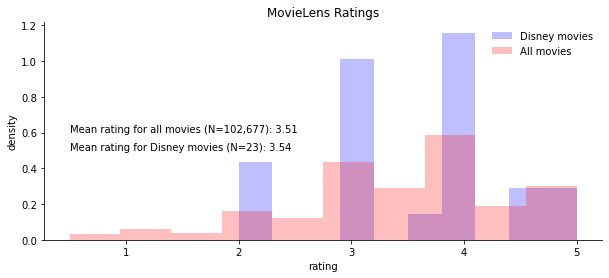

In [28]:
fig, ax = plt.subplots(figsize=(10,4))

# Two histograms one-atop the other
ax.hist(dis['rating'], bins=10, color = 'blue', alpha = 0.25, density=True, label = 'Disney movies')
ax.hist(movie_data_2['rating'], bins=10, color = 'red', alpha = 0.25, density=True, label = 'All movies')

ax.set_title('MovieLens Ratings')
ax.set_xlabel('rating')
ax.set_ylabel('density')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(0.5, 0.6, 'Mean rating for all movies (N={0:,d}): {1:.3}'.format(all_N, all_mean))
ax.text(0.5, 0.5, 'Mean rating for Disney movies (N={0:,d}): {1:.3}'.format(dis_N, dis_mean))

ax.legend(frameon=False)
plt.show()